In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../../../Data/housing_data_TX_encoded.csv',infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="State_TX")
df = df.sort_index()
df

,Date,Identifier,Bedroom,Price,Average_Market_Days,RegionName_Austin,RegionName_Beaumont,RegionName_Brownwood,RegionName_Converse,RegionName_Coppell,...,CountyName_Jefferson County,CountyName_McLennan County,CountyName_Montgomery County,CountyName_Rockwall County,CountyName_Smith County,CountyName_Tarrant County,CountyName_Tom Green County,CountyName_Travis County,CountyName_Val Verde County,CountyName_Williamson County
0,2010-01-31,2,1,67653.0,133.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2010-01-31,2,2,89995.0,133.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2010-01-31,2,3,116641.0,133.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2010-01-31,2,4,167849.0,133.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2010-01-31,2,5,303323.0,133.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7803,2020-02-29,1431,4,240716.0,57.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7804,2020-02-29,2307,4,230132.0,110.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7805,2020-02-29,1241,5,281139.0,72.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7806,2020-02-29,1800,5,141688.0,123.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Citation: https://stackoverflow.com/questions/53731432/return-pandas-multiindex-as-list-of-tuples

arrays = [df["Identifier"].replace(" ",""),
          df["Bedroom"].replace(" ",""),
          df["Date"].replace(" ","")]

tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['Region_ID', 'Bedrooms','Date'])

TX_nbhoods_df = df.set_index(index)
TX_nbhoods_df = TX_nbhoods_df.drop(columns=["Identifier","Bedroom","Date"])
TX_nbhoods_df = TX_nbhoods_df.sort_index()
TX_nbhoods_df

Price  Average_Market_Days  \
Region_ID Bedrooms Date                                        
2         1        2010-01-31   67653.0                133.0   
                   2010-02-28   67444.0                137.0   
                   2010-03-31   67260.0                134.0   
                   2010-04-30   67041.0                112.0   
                   2010-05-31   66721.0                 92.5   
...                                 ...                  ...   
2601      5        2019-10-31  263869.0                 59.0   
                   2019-11-30  264457.0                 54.0   
                   2019-12-31  264356.0                 73.5   
                   2020-01-31  264264.0                 93.5   
                   2020-02-29  264290.0                 91.5   

                               RegionName_Austin  RegionName_Beaumont  \
Region_ID Bedrooms Date                                                 
2         1        2010-01-31                  0                    0   
                   2010-02-28                  0                    0   
                   2010-03-31                  0                    0   
                   2010-04-30                  0                    0   
                   2010-05-31                  0                    0   
...                                          ...                  ...   
2601      5        2019-10-31                  0                    0   
                   2019-11-30                  0                    0   
                   2019-12-31                  0                    0   
                   2020-01-31                  0                    0   
                   2020-02-29                  0                    0   

                               RegionName_Brownwood  RegionName_Converse  \
Region_ID Bedrooms Date                                                    
2         1        2010-01-31                     0                    0   
                   2010-02-28                     0                    0   
                   2010-03-31                     0                    0   
                   2010-04-30                     0                    0   
                   2010-05-31                     0                    0   
...                                             ...                  ...   
2601      5        2019-10-31                     0                    0   
                   2019-11-30                     0                    0   
                   2019-12-31                     0                    0   
                   2020-01-31                     0                    0   
                   2020-02-29                     0                    0   

                               RegionName_Coppell  RegionName_Crosby  \
Region_ID Bedrooms Date                                                
2         1        2010-01-31                   0                  0   
                   2010-02-28                   0                  0   
                   2010-03-31                   0                  0   
                   2010-04-30                   0                  0   
                   2010-05-31                   0                  0   
...                                           ...                ...   
2601      5        2019-10-31                   0                  0   
                   2019-11-30                   0                  0   
                   2019-12-31                   0                  0   
                   2020-01-31                   0                  0   
                   2020-02-29                   0                  0   

                               RegionName_Dallas  RegionName_Del Rio  ...  \
Region_ID Bedrooms Date                                               ...   
2         1        2010-01-31                  0                   0  ...   
                   2010-02-28                  0                   0  ...   
                 

In [4]:
TX_nbhoods_df.index


MultiIndex([(   2, 1, '2010-01-31'),
            (   2, 1, '2010-02-28'),
            (   2, 1, '2010-03-31'),
            (   2, 1, '2010-04-30'),
            (   2, 1, '2010-05-31'),
            (   2, 1, '2010-06-30'),
            (   2, 1, '2010-07-31'),
            (   2, 1, '2010-08-31'),
            (   2, 1, '2010-09-30'),
            (   2, 1, '2010-10-31'),
            ...
            (2601, 5, '2019-05-31'),
            (2601, 5, '2019-06-30'),
            (2601, 5, '2019-07-31'),
            (2601, 5, '2019-08-31'),
            (2601, 5, '2019-09-30'),
            (2601, 5, '2019-10-31'),
            (2601, 5, '2019-11-30'),
            (2601, 5, '2019-12-31'),
            (2601, 5, '2020-01-31'),
            (2601, 5, '2020-02-29')],
           names=['Region_ID', 'Bedrooms', 'Date'], length=7808)

In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
def build_by_region_beds(tuple_,window_size,units,batch):
    region_bed = tuple_[:2]
    region_bed_df = TX_nbhoods_df.loc[region_bed]
    prices_df = region_bed_df.loc[:,["Price"]]
    prices_df.sort_index(inplace=True)
    feature_column = 0
    target_column = 0
    X, y = window_data(prices_df, window_size, feature_column, target_column)

    split = int(0.7 * len(X))
    X_train = X[: split]
    X_old = prices_df
    X_old.rename(columns={"Price":"Real"},inplace=True)
    X_test = X[(split - window_size):]
    y_train = y[: split]
    y_test = y[(split - window_size):]

    scaler = MinMaxScaler()
    scaler.fit(X)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    scaler.fit(y)
    y_train = scaler.transform(y_train)
    y_test = scaler.transform(y_test)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    model = Sequential()

    number_units = units
    dropout_fraction = 0.2


    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )
    model.add(Dropout(dropout_fraction))

    model.add(LSTM(units=number_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))

    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mean_squared_error")


    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=batch, verbose=1)

    loss = model.evaluate(X_test, y_test)
    predicted = model.predict(X_test)

    predicted_prices = scaler.inverse_transform(predicted.reshape(-1,1))
    real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    real_ = real_prices.ravel()
    predicted_ = predicted_prices.ravel()

    index= [f'{date[:-3][5:7]}-{date[:-3][2:4]}' for date in X_old.index]
    final_df = pd.DataFrame({
        "Real": real_[window_size:],
        "Predicted": predicted_[window_size:]},
        index= index[-len(real_[window_size:]):]) 
    

    return [final_df, loss, X_old]


In [7]:
presentation_tuples = [(4,1),(9,2),(2,3),(10,4)]

rgument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 [==============================] - 0s 3ms/step - loss: 0.0086
Epoch 1/10
16/16 [==============================] - 0s 18ms/step - loss: 0.0046
Epoch 2/10
16/16 [==============================] - 0s 18ms/step - loss: 0.0411
Epoch 3/10
16/16 [==============================] - 0s 19ms/step - loss: 0.0062
Epoch 4/10
16/16 [==============================] - 0s 21ms/step - loss: 0.0176
Epoch 5/10
16/16 [==============================] - 0s 21ms/step - loss: 0.0079
Epoch 6/10
16/16 [==============================] - 0s 18ms/step - loss: 0.0152
Epoch 7/10
16/16 [==============================] - 0s 19ms/step - loss: 0.0071
Epoch 8/10
16/16 [==============================] - 0s 19ms/step - loss: 0.0081
Epoch 9/10
16/16 [==============================] - 0

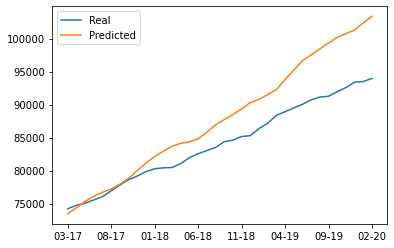

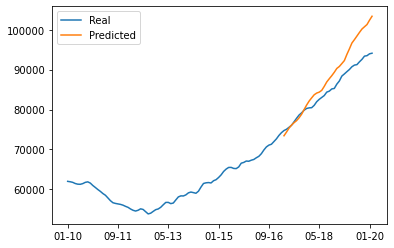

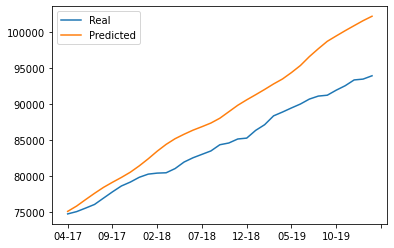

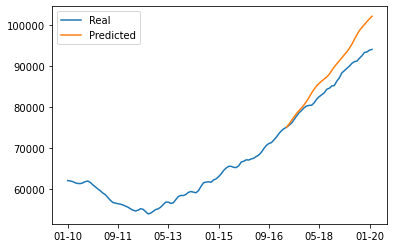

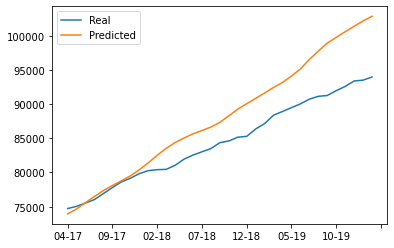

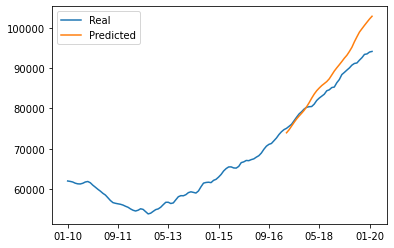

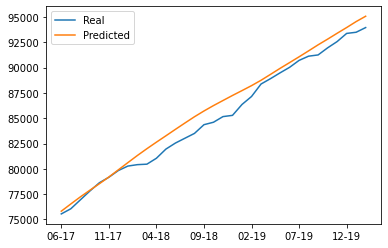

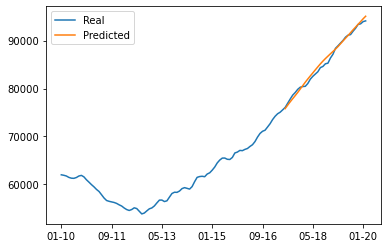

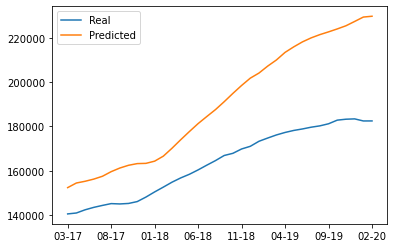

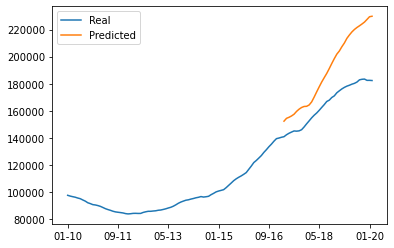

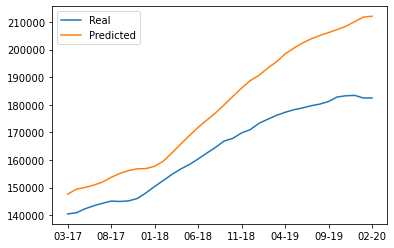

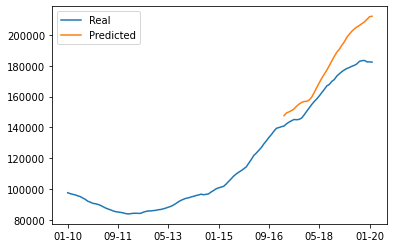

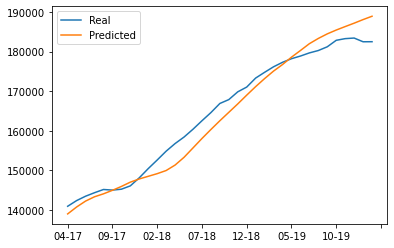

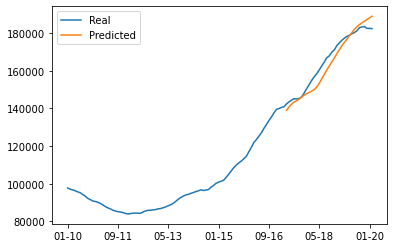

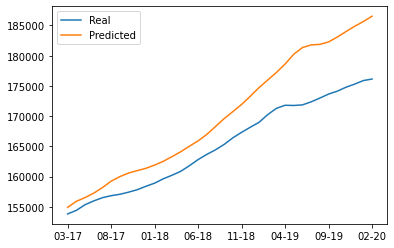

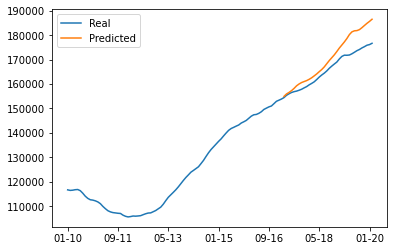

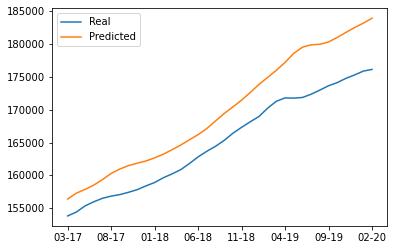

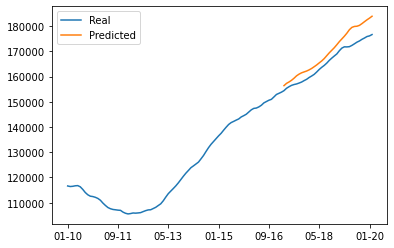

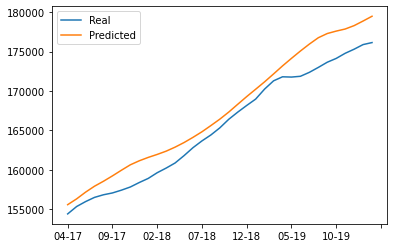

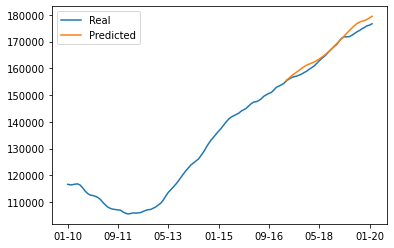

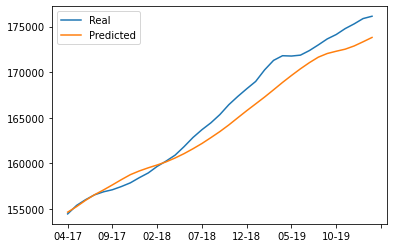

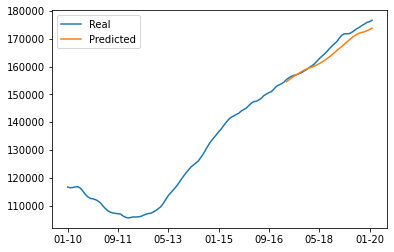

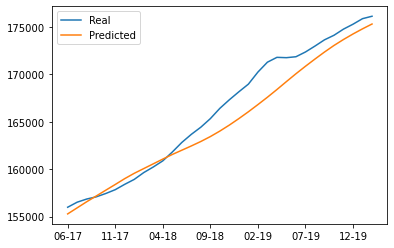

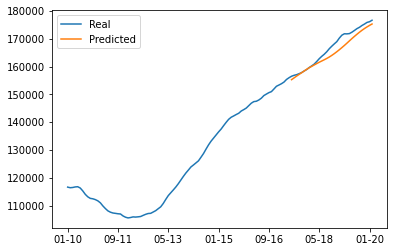

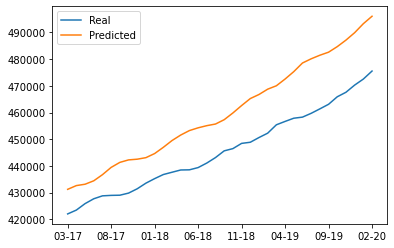

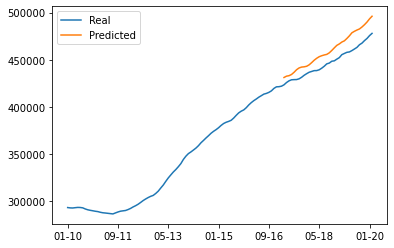

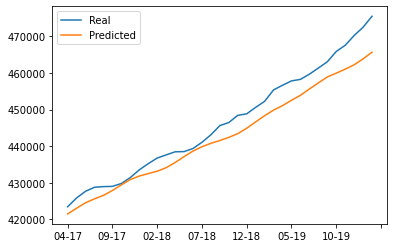

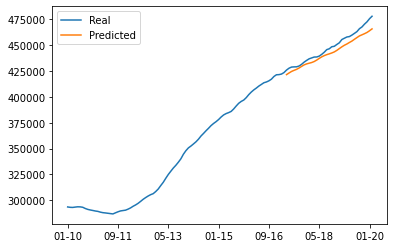

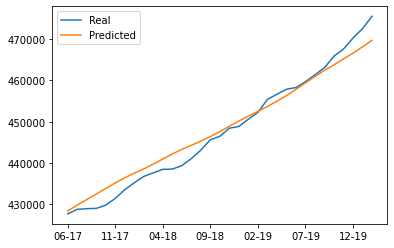

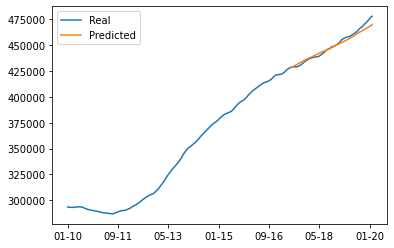

In [12]:
for tuple_ in presentation_tuples:
    path = f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/'

    if os.path.isdir(path)==False:
        os.makedirs(path)
        #Citation: https://docs.python.org/3/tutorial/controlflow.html
        continue

    elif len(os.listdir(path)) == 0:

        loss_to_beat = 1

        for i in [3,6,12]:
            for units in [30,50,100]:
                for batch in [5,25,125]:
                    model = build_by_region_beds(tuple_,i,units,batch)
                    output = model[0]
                    loss_val = model[1]

                    #Citation: https://www.geeksforgeeks.org/python-pandas-isnull-and-notnull/
                    if type(loss_val)!=float:
                        pass
                    elif loss_val > loss_to_beat:
                        pass
                    else:
                        old_prices = model[2]
                        old_prices["Date"] = [f'{date[:-3][5:7]}-{date[:-3][2:4]}' for date in old_prices.index]
                        old_prices.reset_index(inplace=True,drop=True)
                        old_prices.set_index("Date",inplace=True,drop=True)
                        index = pd.MultiIndex.from_tuples([tuple_[:2]],names=["Region","Bedrooms"])
                        #Note to self: If you don't end up figuring out why its predicting Nan's for some of them, remember to drop those region_beds from the data before AWS run (window too large for some datasets?)
                        loss = pd.DataFrame(columns={"Loss":loss_val},index=index)
                        loss["Loss"] = loss_val
                        Predicted_vs_Real = output.plot()
                        Train_vs_Test = pd.concat([old_prices, output["Predicted"]],axis=1,join='outer')
                        Train_vs_Test_plt = Train_vs_Test.plot()

                        parameters = pd.DataFrame({"Window":i, "Units":units,"Batch_Size":batch},index=index)
                        parameters.to_csv(f'{path}Optimal_Parameters.csv')

                        output.to_csv(f'{path}Results.csv')
                        loss.to_csv(f'{path}Loss.csv') 

                        # Citation: https://stackoverflow.com/questions/18992086/save-a-pandas-series-histogram-plot-to-file
                        Predicted_vs_Real.figure.savefig(f'{path}Plot.png')
                        Train_vs_Test_plt.figure.savefig(f'{path}Plot2.png')
                        loss_to_beat = loss_val
    else:
        print(f'Already have for Region {tuple_[0]}, {tuple_[1]} Bedroom.')
        pass

In [13]:
#Citation: https://stackoverflow.com/questions/814167/easiest-way-to-rm-rf-in-python
# import shutil
# for region in os.listdir('../Results/Region'):
#     region_files = os.listdir(f'../Results/Region/{region}/')
#     if len(region_files)==0:
#         shutil.rmtree(f'../Results/Region/{region}/')
#     else:
#         for bedroom in os.listdir(f'../Results/Region/{region}/Bedrooms/'):
#             bedroom_files = os.listdir(f'../Results/Region/{region}/Bedrooms/{bedroom}')
#             if len(bedroom_files)==0:
#                 shutil.rmtree(f'../Results/Region/{region}/Bedrooms/{bedroom}/')

In [14]:
# ## OLD FOR-LOOP IN CASE THE NEW ONE BREAKS:
# for tuple_ in set(TX_nbhoods_df.index):
#     for i in [1,3,6,12]:
#         model = build_by_region_beds(tuple_,i)
#         output = model[0]
#         loss_val = model[1]
#         old_prices = model[2]
#         index = pd.MultiIndex.from_tuples([tuple_[:2]],names=["Region","Bedrooms"])
#         #Note to self: If you don't end up figuring out why its predicting Nan's for some of them, remember to drop those region_beds from the data before AWS run (window too large for some datasets?)
#         loss = pd.DataFrame(columns={"Loss":loss_val},index=index)
#         loss["Loss"] = loss_valgit 
#         Predicted_vs_Real = output.plot()
#         Train_vs_Test = pd.concat([old_prices, output["Predicted"]],axis=1,join='outer')
#         print(Train_vs_Test)
#         Train_vs_Test_plt = Train_vs_Test.plot()

#         path = f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/'
        
        
#         if os.path.isdir(path)==True:
#             pass
            
#         else:
#             os.makedirs(path)
#         output.to_csv(f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/Results.csv')
#         loss.to_csv(f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/Loss.csv') 

#         # Citation: https://stackoverflow.com/questions/18992086/save-a-pandas-series-histogram-plot-to-file
#         Predicted_vs_Real.figure.savefig(f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/Plot.png')
#         Train_vs_Test_plt.figure.savefig(f'../Results/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/Plot2.png')

In [15]:
# NEW FOR-LOOP IN CASE NEWER ONE BREAKS
# for tuple_ in set(TX_nbhoods_df.index):
#     for i in [1,3,6,12]:
#         path = f'../Results/New/Region/{tuple_[0]}/Bedrooms/{tuple_[1]}/Window-Size/{str(i)}/'
#         if os.path.isdir(path)==False:
#             os.makedirs(path)
#             #Citation: https://docs.python.org/3/tutorial/controlflow.html
#             continue
#         else:
#             pass

#         file_list = os.listdir(path)
        
#         if len(file_list)==4:
#             print(f'Already have for Region {tuple_[0]}, {tuple_[1]} Bedroom with window size {i}: {file_list}')
#             pass
#         else:
#             model = build_by_region_beds(tuple_,i)
#             output = model[0]
#             loss_val = model[1]
#             old_prices = model[2]
#             index = pd.MultiIndex.from_tuples([tuple_[:2]],names=["Region","Bedrooms"])
#             #Note to self: If you don't end up figuring out why its predicting Nan's for some of them, remember to drop those region_beds from the data before AWS run (window too large for some datasets?)
#             loss = pd.DataFrame(columns={"Loss":loss_val},index=index)
#             loss["Loss"] = loss_val
#             Predicted_vs_Real = output.plot()
#             Train_vs_Test = pd.concat([old_prices, output["Predicted"]],axis=1,join='outer')
#             Train_vs_Test_plt = Train_vs_Test.plot()

#             output.to_csv(f'{path}Results.csv')
#             loss.to_csv(f'{path}Loss.csv') 

#             # Citation: https://stackoverflow.com/questions/18992086/save-a-pandas-series-histogram-plot-to-file
#             Predicted_vs_Real.figure.savefig(f'{path}Plot.png')
#             Train_vs_Test_plt.figure.savefig(f'{path}Plot2.png')